In [1]:
#Import all the libraries
import argparse
import os
import numpy as np
import math
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import sys
from torchvision.utils import make_grid
from torch.optim import Adam
from torch import nn
import torch
import torchvision.utils as vutils
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import numpy as np
import random
import gc

In [2]:
# Set device to GPU if CUDA is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [3]:
!pip install kaggle

In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

In [5]:
#Downloading the dataset
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:13<00:00, 26.4MB/s]
100% 1.33G/1.33G [00:13<00:00, 104MB/s] 


In [6]:
import zipfile
# Define the path to your zip file
file_path = '/content/celeba-dataset.zip'  # Replace 'your_file.zip' with your file's name

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

In [7]:
dataset_folder_path = '/content/images'

In [8]:
# Image Transformation
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [9]:
dataset = datasets.ImageFolder('/content/img_align_celeba', transform)

Train Dataloader

In [10]:
# Select the first 4096 samples
selected_indices = range(4096)
selected_dataset = torch.utils.data.Subset(dataset, selected_indices)

In [11]:
dataloader = DataLoader(dataset = selected_dataset, batch_size= 64, shuffle = True, num_workers = 2)

Validation Dataloader

In [12]:
# Select the first 10,000 samples
val_indices = range(4096 , 5248)
val_dataset = torch.utils.data.Subset(dataset, selected_indices)

In [13]:
val_dataloader = DataLoader(dataset = val_dataset, batch_size= 64, shuffle = True, num_workers = 2)

Parser Commands - (makes it very easy to keep track of values)

In [14]:
os.makedirs("images", exist_ok=True)
sys.argv = [arg for arg in sys.argv if not arg.startswith("-")]
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=20, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--code_dim", type=int, default=2, help="latent code")
parser.add_argument("--n_classes", type=int, default=10, help="number of classes for dataset")
parser.add_argument("--img_size", type=int, default= 64, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=3, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval between image sampling")
opt, unknown_args = parser.parse_known_args()
print(opt)

Namespace(n_epochs=20, batch_size=64, lr=0.0002, b1=0.5, b2=0.999, n_cpu=8, latent_dim=100, code_dim=2, n_classes=10, img_size=64, channels=3, sample_interval=400)


In [15]:
# Defining/ Initializng weights for the GANs
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [16]:
# One-hot encoding
def to_categorical(y, num_columns):
    """Converts class labels to one-hot encoded vectors."""
    y = y.astype(int)
    y_cat = np.zeros((y.shape[0], num_columns))
    y_cat[np.arange(y.shape[0]), y] = 1.0
    return Variable(FloatTensor(y_cat))

### **Generator and Discriminator**

*   The generator is from InfoGAN and Discriminator is of DCGAN.





In [22]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        input_dim = opt.latent_dim + opt.n_classes + opt.code_dim

        self.init_size = opt.img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(input_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels, code):
        gen_input = torch.cat((noise, labels, code), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

##Min-Max Loss

Here I have Implemented the Min-Max Loss, Basically we increase the loss of discriminator per epoch and try to decrease the generator.

<ipython-input-23-ff4535a94fc3>:52: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  z = Variable(Tensor(np.random.normal(0, 1, (opt.batch_size, opt.latent_dim))))


[Epoch 0/20] [Batch 0/64] [D loss: 1.386263] [G loss: 0.699439]
[Epoch 0/20] [Batch 1/64] [D loss: 1.386077] [G loss: 0.698728]
[Epoch 0/20] [Batch 2/64] [D loss: 1.386007] [G loss: 0.698076]
[Epoch 0/20] [Batch 3/64] [D loss: 1.385838] [G loss: 0.697457]
[Epoch 0/20] [Batch 4/64] [D loss: 1.385496] [G loss: 0.696929]
[Epoch 0/20] [Batch 5/64] [D loss: 1.385209] [G loss: 0.696374]
[Epoch 0/20] [Batch 6/64] [D loss: 1.384714] [G loss: 0.695838]
[Epoch 0/20] [Batch 7/64] [D loss: 1.384527] [G loss: 0.695381]
[Epoch 0/20] [Batch 8/64] [D loss: 1.383120] [G loss: 0.695058]
[Epoch 0/20] [Batch 9/64] [D loss: 1.382599] [G loss: 0.694906]
[Epoch 0/20] [Batch 10/64] [D loss: 1.381035] [G loss: 0.694592]
[Epoch 0/20] [Batch 11/64] [D loss: 1.380500] [G loss: 0.694335]
[Epoch 0/20] [Batch 12/64] [D loss: 1.379682] [G loss: 0.693613]
[Epoch 0/20] [Batch 13/64] [D loss: 1.374667] [G loss: 0.692746]
[Epoch 0/20] [Batch 14/64] [D loss: 1.375447] [G loss: 0.690611]
[Epoch 0/20] [Batch 15/64] [D loss:

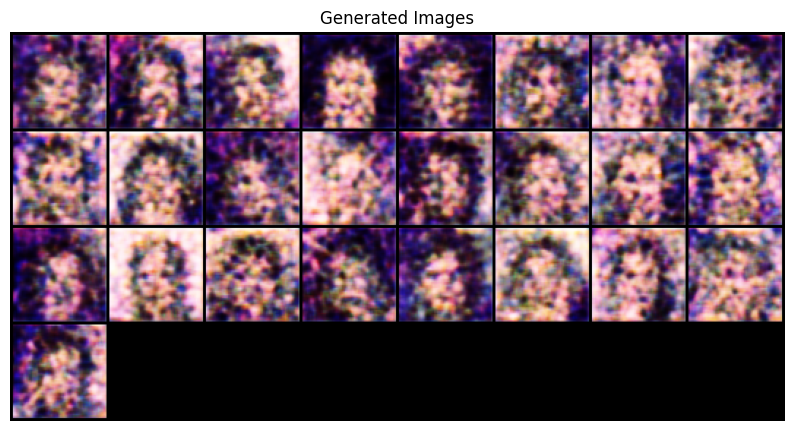

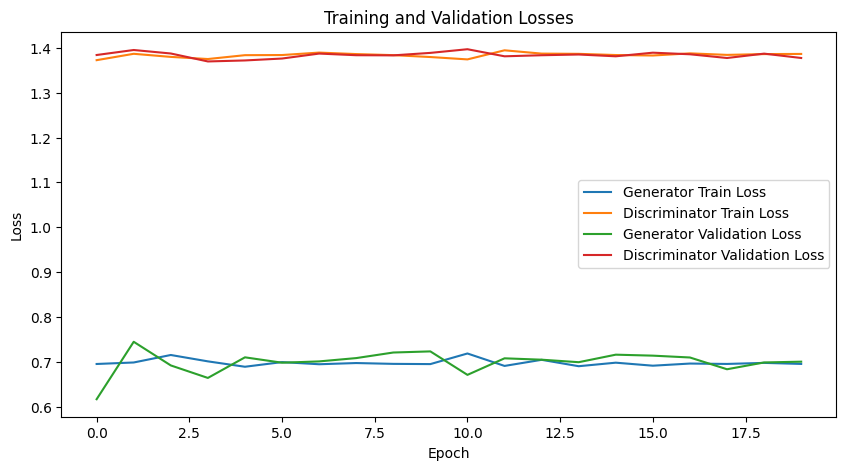

In [23]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

# Training and validation loop
train_loss_G = []
train_loss_D = []
val_loss_G = []
val_loss_D = []
fid_scores = []

for epoch in range(opt.n_epochs):

    epoch_loss_G = 0.0
    epoch_loss_D = 0.0
    for i, (imgs, _) in enumerate(dataloader):



        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (opt.batch_size, opt.latent_dim))))
        label_input = to_categorical(np.random.randint(0, opt.n_classes, opt.batch_size), num_columns=opt.n_classes)
        code_input = Variable(FloatTensor(np.random.uniform(-1, 1, (opt.batch_size, opt.code_dim))))


        # Generate a batch of images
        gen_imgs = generator(z, label_input, code_input)

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Loss measures generator's ability to fool the discriminator
        g_loss = (adversarial_loss(discriminator(gen_imgs), valid))

        g_loss.backward()
        optimizer_G.step()

        epoch_loss_G += g_loss.item()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

        epoch_loss_D += d_loss.item()



        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        # batches_done = epoch * len(dataloader) + i
        # if batches_done % opt.sample_interval == 0:
        #     save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

    # Store epoch losses
    train_loss_G.append(epoch_loss_G / len(dataloader))
    train_loss_D.append(epoch_loss_D / len(dataloader))




    # Validation loop
    with torch.no_grad():
        val_loss_G_epoch = 0.0
        val_loss_D_epoch = 0.0
        for i, (val_imgs, _) in enumerate(val_dataloader):
            val_imgs = val_imgs.to(device)

            # Adversarial ground truths for validation
            valid = Variable(Tensor(val_imgs.shape[0], 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(val_imgs.shape[0], 1).fill_(0.0), requires_grad=False)

            # Sample noise as generator input
            z = Variable(Tensor(np.random.normal(0, 1, (val_imgs.shape[0], opt.latent_dim))))
            label = to_categorical(np.random.randint(0, opt.n_classes, opt.batch_size), num_columns=opt.n_classes)
            code= Variable(FloatTensor(np.random.uniform(-1, 1, (opt.batch_size, opt.code_dim))))

            # Generate a batch of images
            gen_imgs = generator(z , label , code)

            # Loss measures generator's ability to fool the discriminator
            val_loss_G_batch = adversarial_loss(discriminator(gen_imgs), valid)
            val_loss_G_epoch += val_loss_G_batch.item()

            # Measure discriminator's ability to classify real images
            real_loss = adversarial_loss(discriminator(val_imgs), valid)

            # Measure discriminator's ability to classify fake images
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)

            # Total discriminator loss
            val_loss_D_batch = real_loss + fake_loss
            val_loss_D_epoch += val_loss_D_batch.item()

        # Store validation losses
        val_loss_G.append(val_loss_G_epoch / len(val_dataloader))
        val_loss_D.append(val_loss_D_epoch / len(val_dataloader))





    # Visualize the images
    if (epoch+1) % 20 == 0:
        # Generate and save images
        save_image(gen_imgs.data[:25], "images/%d.png" % epoch, nrow=5, normalize=True)

        # Plot generated images
        fig = plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.title("Generated Images")
        plt.imshow(np.transpose(vutils.make_grid(gen_imgs.data[:25], padding=2, normalize=True).cpu(), (1, 2, 0)))
        plt.show()

#print(val_loss_G)

# Plotting losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss_G, label="Generator Train Loss")
plt.plot(train_loss_D, label="Discriminator Train Loss")
plt.plot(val_loss_G, label="Generator Validation Loss")
plt.plot(val_loss_D, label="Discriminator Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.show()

###Least-square Gan Loss

In [24]:
# ----- DEFINE LOSS FUNC ------
# Generator loss
def generator_loss(discriminator_output_fake):
    return 0.5 * torch.mean((discriminator_output_fake - 1) ** 2)

# Discriminator loss
def discriminator_loss(discriminator_output_real, discriminator_output_fake):
    loss_real = 0.5 * torch.mean((discriminator_output_real - 1) ** 2)
    loss_fake = 0.5 * torch.mean(discriminator_output_fake ** 2)
    return loss_real + loss_fake

[Epoch 0/20] [Batch 0/64] [D loss: 0.000007] [G loss: 0.498917]
[Epoch 0/20] [Batch 1/64] [D loss: 0.000021] [G loss: 0.497344]
[Epoch 0/20] [Batch 2/64] [D loss: 0.000049] [G loss: 0.498739]
[Epoch 0/20] [Batch 3/64] [D loss: 0.000084] [G loss: 0.498407]
[Epoch 0/20] [Batch 4/64] [D loss: 0.000043] [G loss: 0.498656]
[Epoch 0/20] [Batch 5/64] [D loss: 0.000004] [G loss: 0.497822]
[Epoch 0/20] [Batch 6/64] [D loss: 0.000037] [G loss: 0.497824]
[Epoch 0/20] [Batch 7/64] [D loss: 0.000034] [G loss: 0.496025]
[Epoch 0/20] [Batch 8/64] [D loss: 0.000005] [G loss: 0.498663]
[Epoch 0/20] [Batch 9/64] [D loss: 0.000038] [G loss: 0.498646]
[Epoch 0/20] [Batch 10/64] [D loss: 0.000039] [G loss: 0.498445]
[Epoch 0/20] [Batch 11/64] [D loss: 0.000039] [G loss: 0.497827]
[Epoch 0/20] [Batch 12/64] [D loss: 0.000004] [G loss: 0.497941]
[Epoch 0/20] [Batch 13/64] [D loss: 0.000067] [G loss: 0.498423]
[Epoch 0/20] [Batch 14/64] [D loss: 0.000009] [G loss: 0.498565]
[Epoch 0/20] [Batch 15/64] [D loss:

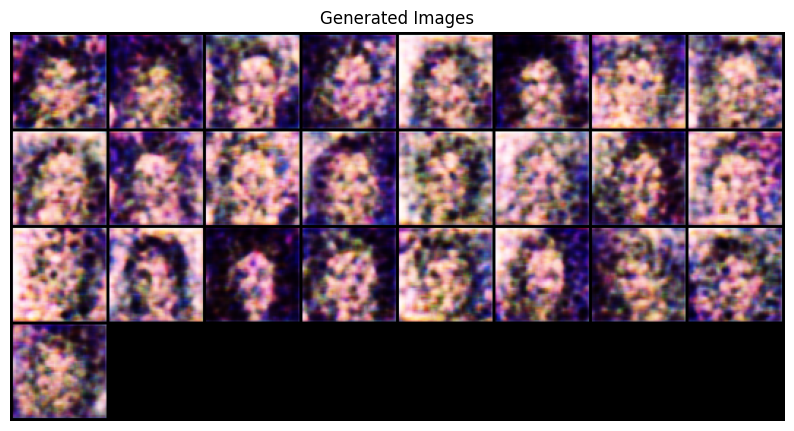

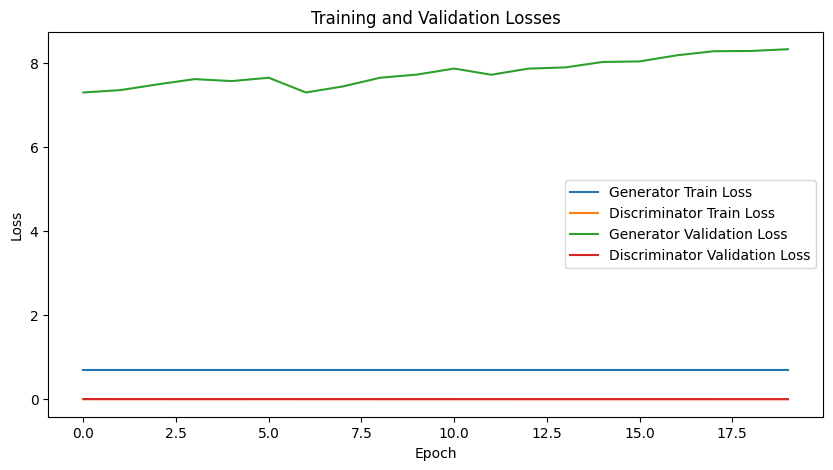

In [27]:
# Training and validation loop
train_loss_G = []
train_loss_D = []
val_loss_G = []
val_loss_D = []

for epoch in range(opt.n_epochs):
    epoch_loss_G = 0.0
    epoch_loss_D = 0.0
    for i, (imgs, _) in enumerate(dataloader):
        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (opt.batch_size, opt.latent_dim))))
        label_input = to_categorical(np.random.randint(0, opt.n_classes, opt.batch_size), num_columns=opt.n_classes)
        code_input = Variable(FloatTensor(np.random.uniform(-1, 1, (opt.batch_size, opt.code_dim))))

        # Generate a batch of images
        gen_imgs = generator(z, label_input, code_input)

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)



        # Loss measures generator's ability to fool the discriminator
        g_loss2 = generator_loss(discriminator(gen_imgs.detach()))
        g_loss2.backward()
        optimizer_G.step()

        epoch_loss_G += g_loss.item()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        # Calculate discriminator loss
        discriminator_output_real = discriminator(real_imgs)
        discriminator_output_fake = discriminator(gen_imgs.detach())
        d_loss = discriminator_loss(discriminator_output_real, discriminator_output_fake)
        d_loss.backward(retain_graph=True)
        optimizer_D.step()

        epoch_loss_D += d_loss.item()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss2.item())
        )

        # batches_done = epoch * len(dataloader) + i
        # if batches_done % opt.sample_interval == 0:
        #     save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

    # Store epoch losses
    train_loss_G.append(epoch_loss_G / len(dataloader))
    train_loss_D.append(epoch_loss_D / len(dataloader))

    # Validation loop
    with torch.no_grad():
        val_loss_G_epoch = 0.0
        val_loss_D_epoch = 0.0
        for i, (val_imgs, _) in enumerate(val_dataloader):
            # Move validation data to GPU if available
            val_imgs = val_imgs.to(device)

            # Adversarial ground truths for validation
            valid = Variable(Tensor(val_imgs.shape[0], 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(val_imgs.shape[0], 1).fill_(0.0), requires_grad=False)

            # Sample noise as generator input
            z = Variable(Tensor(np.random.normal(0, 1, (val_imgs.shape[0], opt.latent_dim))))
            label = to_categorical(np.random.randint(0, opt.n_classes, opt.batch_size), num_columns=opt.n_classes)
            code= Variable(FloatTensor(np.random.uniform(-1, 1, (opt.batch_size, opt.code_dim))))

            # Generate a batch of images
            gen_imgs = generator(z , label , code)

            # Loss measures generator's ability to fool the discriminator
            val_loss_G_batch = adversarial_loss(discriminator(gen_imgs), valid)
            val_loss_G_epoch += val_loss_G_batch.item()

            # Measure discriminator's ability to classify real images
            real_loss = adversarial_loss(discriminator(val_imgs), valid)

            # Measure discriminator's ability to classify fake images
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)

            # Total discriminator loss
            val_loss_D_batch = real_loss + fake_loss
            val_loss_D_epoch += val_loss_D_batch.item()

        # Store validation losses
        val_loss_G.append(val_loss_G_epoch / len(val_dataloader))
        val_loss_D.append(val_loss_D_epoch / len(val_dataloader))


    # Visualize the images
    if (epoch+ 1)% 20 == 0:
        # Generate and save images
        save_image(gen_imgs.data[:25], "images/%d.png" % epoch, nrow=5, normalize=True)

        # Plot generated images
        fig = plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.title("Generated Images")
        plt.imshow(np.transpose(vutils.make_grid(gen_imgs.data[:25], padding=2, normalize=True).cpu(), (1, 2, 0)))
        plt.show()


# Plotting losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss_G, label="Generator Train Loss")
plt.plot(train_loss_D, label="Discriminator Train Loss")
plt.plot(val_loss_G, label="Generator Validation Loss")
plt.plot(val_loss_D, label="Discriminator Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.show()

